In [1]:
!nvidia-smi

Thu Apr 17 17:13:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 572.70         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P0             16W /   47W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-04-17 17:13:40.304794: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-17 17:13:40.488397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744884820.550350     662 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744884820.568210     662 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-17 17:13:40.715453: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [15]:
# Binary Convolutional Layer with STE
class BinaryConv2D(layers.Layer):
    def __init__(self, filters, kernel_size, strides=(1,1), padding='same', **kwargs):
        super(BinaryConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding

    def build(self, input_shape):
        # Full-precision weights storage
        self.kernel = self.add_weight(
            name='kernel',
            shape=(self.kernel_size, self.kernel_size, input_shape[-1], self.filters),
            initializer='glorot_uniform',
            trainable=True
        )
        super(BinaryConv2D, self).build(input_shape)
        
    @tf.custom_gradient
    def binarize(self, weights):
        def grad(dy, variables=None):
            return dy  # Straight-Through Estimator
        return tf.sign(weights), grad

    def call(self, inputs):
        binary_kernel = self.binarize(self.kernel)
        return tf.nn.conv2d(
            inputs,
            binary_kernel,
            strides=[1, self.strides[0], self.strides[1], 1],
            padding=self.padding.upper()
        )

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding,
        })
        return config
        
# Build Binary CNN Model
def create_binary_model():
    model = models.Sequential([
        # Input layer
        layers.InputLayer(shape=(28, 28, 1)),
        
        # Block 1
        BinaryConv2D(4, 3, padding='same', name='conv1'),
        layers.BatchNormalization(name='batchnormalize1'),
        layers.ReLU(name='activation1'),
        BinaryConv2D(4, 3, padding='same', name='conv2'),
        layers.BatchNormalization(name='batchnormalize2'),
        layers.ReLU(name='activation2'),
        layers.MaxPooling2D(2, name='pool1'),
        
        # Block 2
        BinaryConv2D(8, 3, padding='same', name='conv3'),
        layers.BatchNormalization(name='batchnormalize3'),
        layers.ReLU(name='activation3'),
        BinaryConv2D(8, 3, padding='same', name='conv4'),
        layers.BatchNormalization(name='batchnormalize4'),
        layers.ReLU(name='activation4'),
        layers.MaxPooling2D(2, name='pool2'),
        
        # Block 3
        BinaryConv2D(16, 3, padding='same', name='conv5'),
        layers.BatchNormalization(name='batchnormalize5'),
        layers.ReLU(name='activation5'),
        layers.GlobalMaxPooling2D(name='pool3'),
        
        # Output
        layers.Dense(10, activation='softmax', name='dense1')
    ])
    return model

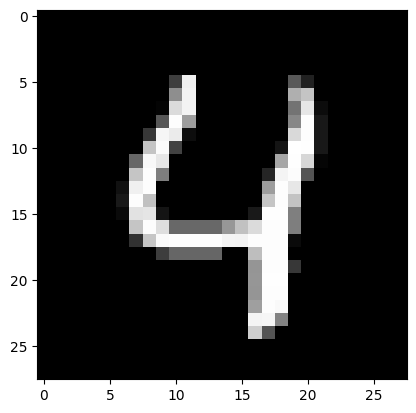

00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
00000000
0

In [6]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

plt.imshow(x_test[4], cmap=cm.Greys_r)
plt.show()
for t in x_test[4].flatten():
    # print(str(t) + ', ', end='')
    print("{:08b}".format(t))
# print("{:08b}".format(y_test[2]))
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255
x_train = (x_train - 0.5) * 2.0  # Scale to [-1, 1]
x_test = (x_test - 0.5) * 2.0


In [ ]:
## Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

# Learning Rate Scheduling
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=600,  # Decay every 600 steps (≈2 epochs)
    decay_rate=0.9,
    staircase=True
)
# cosine annealing
# lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate,
#     decay_steps=20*len(x_train)//128
# )

# optimizer=tf.keras.optimizers.Adam(
#     learning_rate=lr_schedule,
#     clipvalue=0.5
# )
# Create and compile model
model = create_binary_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# model.compile(optimizer=tf.keras.optimizers.SGD(
#                     learning_rate=lr_schedule,
#                     momentum=0.9,
#                     nesterov=False,
#                     weight_decay=1e-4,
#                     clipnorm=None,
#                     clipvalue=0.5,
#                     global_clipnorm=None,
#                     use_ema=False,
#                     ema_momentum=0.99,
#                     ema_overwrite_frequency=None,
#                     loss_scale_factor=None,
#                     gradient_accumulation_steps=None,
#                     name="SGD",
#                 ),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

model.summary()

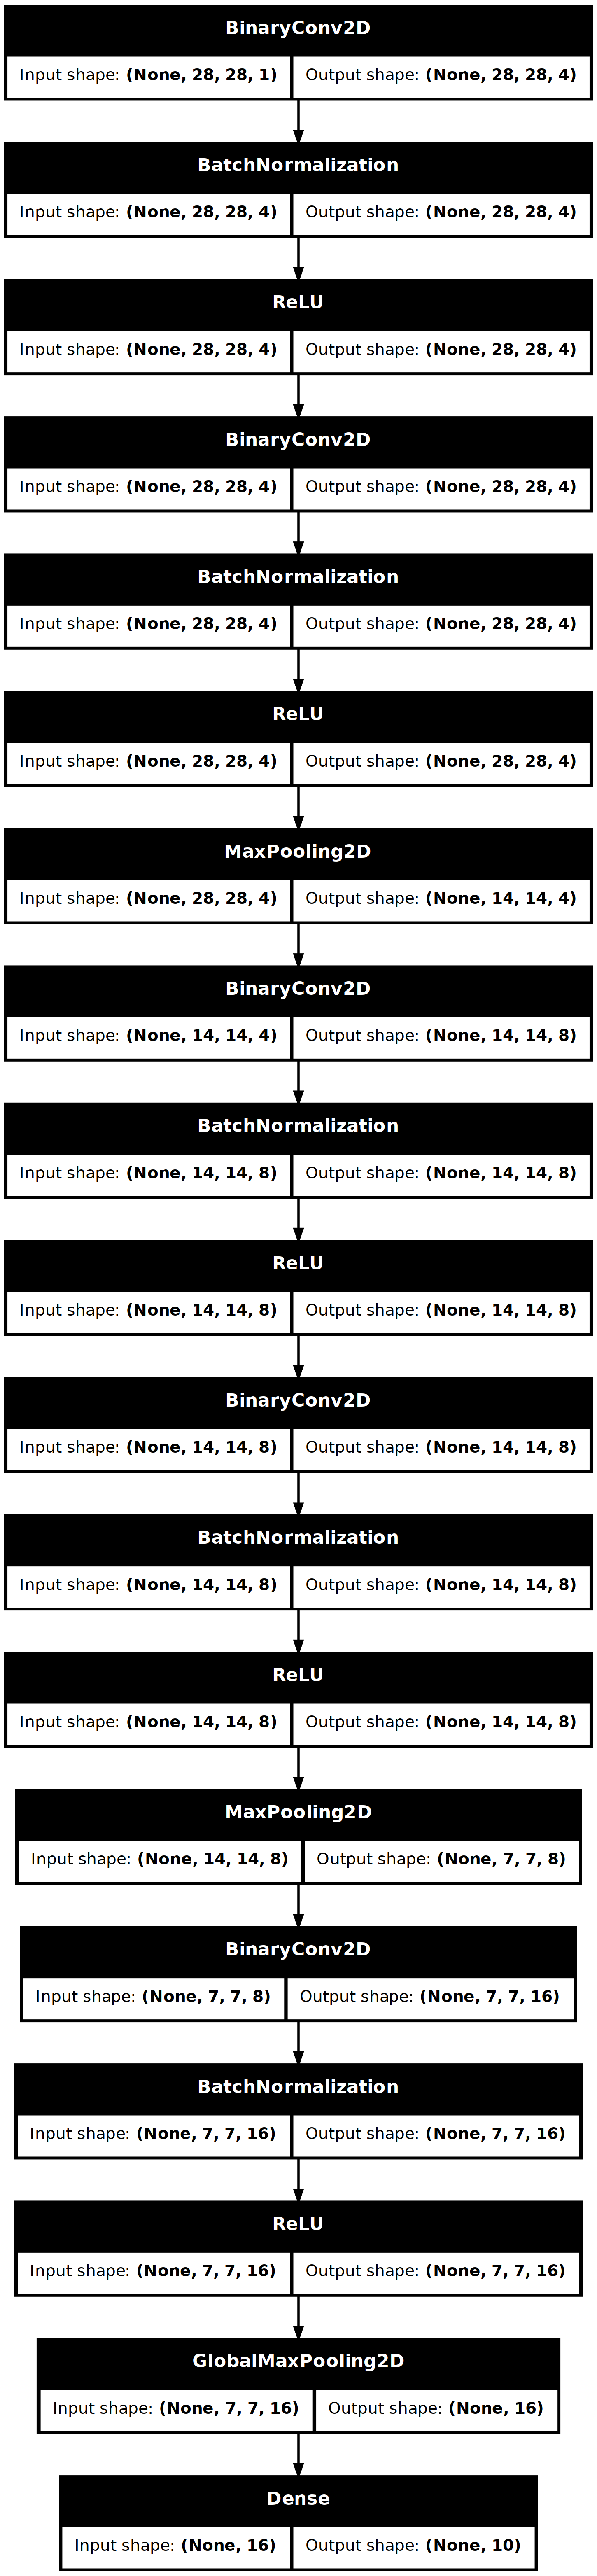

In [18]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [19]:
# Create callbacks
checkpoint_path = "training_1/cp6.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

# ModelCheckpoint to save the best model
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    save_best_only=True,  # Save only the best model
    monitor='val_loss',    # Monitor validation loss
    mode='min',            # Minimization mode for val_loss
    verbose=1
)

# EarlyStopping callback
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=5,            # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore weights from the best epoch
)

# Train with augmented data
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=128),
    steps_per_epoch=len(x_train) // 128,
    epochs=30,             # Maximum number of epochs
    validation_data=(x_test, y_test),
    verbose=1,
    callbacks=[cp_callback, early_stop]  # Both callbacks added
)


Epoch 1/30


/home/nhat/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


467/468 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3788 - loss: 1.9381
Epoch 1: val_loss improved from inf to 0.94795, saving model to training_1/cp6.keras
468/468 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.3795 - loss: 1.9359 - val_accuracy: 0.7110 - val_loss: 0.9480
Epoch 2/30
  1/468 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.8203 - loss: 0.7612

/home/nhat/.local/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.94795
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8203 - loss: 0.7612 - val_accuracy: 0.6396 - val_loss: 1.0399
Epoch 3/30
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8063 - loss: 0.7357
Epoch 3: val_loss improved from 0.94795 to 0.77794, saving model to training_1/cp6.keras
468/468 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.8063 - loss: 0.7355 - val_accuracy: 0.7520 - val_loss: 0.7779
Epoch 4/30
  1/468 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.8750 - loss: 0.5766
Epoch 4: val_loss did not improve from 0.77794
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.5766 - val_accuracy: 0.6369 - val_loss: 1.1768
Epoch 5/30
467/468 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8701 - loss: 0.4780
Epoch 5: val_loss improved from 0.77794 to 0.41616, saving model to training_1/cp6.keras
468/468 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.8701 - loss: 0.4778 - val_accuracy: 0.8807 - val_loss: 

In [8]:
# Create callbacks
checkpoint_path = "training_1/cp5.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

/home/nhat/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 35 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


313/313 - 2s - 5ms/step - accuracy: 0.9236 - loss: 0.2533
Restored model, accuracy: 92.36%


In [ ]:
# for layer in model.layers: print(layer.get_config(), layer.get_weights())
# Check weights in first convolutional layer
conv1_weights = model.get_layer('conv1').get_weights()[0][:, :, 0, 0]
print("Unique weight values after binarization:", tf.sign(conv1_weights).numpy())

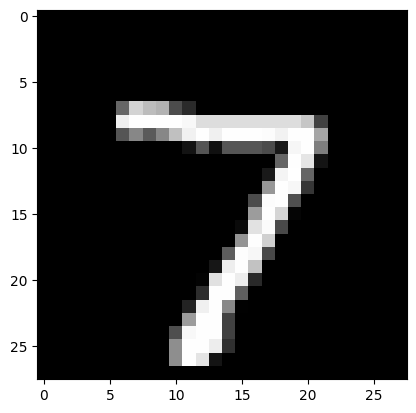

[[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.  

In [64]:
mnist_og = x_test[0]
plt.imshow(mnist_og, cmap=cm.Greys_r)
plt.show()
print(mnist_og.reshape(28,28))
# mnist_og
mnist_og.shape
mnist_og = np.expand_dims(mnist_og, axis=0)
prediction = model.predict(mnist_og)
print(prediction[0])
print(np.argmax(prediction[0]))

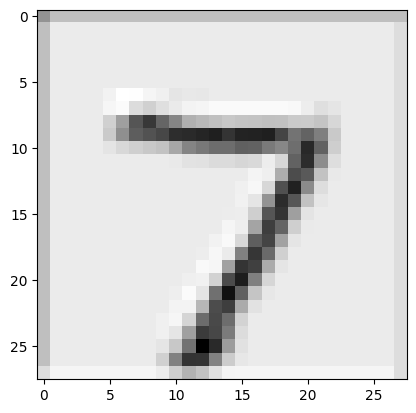

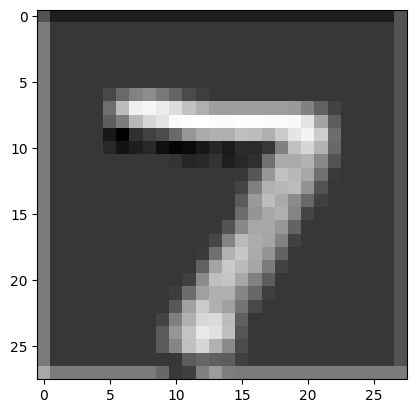

[[ 0.000e+00  2.000e+00  2.000e+00  2.000e+00  2.000e+00  2.000e+00
   2.000e+00  2.000e+00  2.000e+00  2.000e+00  2.000e+00  2.000e+00
   2.000e+00  2.000e+00  2.000e+00  2.000e+00  2.000e+00  2.000e+00
   2.000e+00  2.000e+00  2.000e+00  2.000e+00  2.000e+00  2.000e+00
   2.000e+00  2.000e+00  2.000e+00  2.000e+00]
 [ 2.000e+00  5.000e+00  5.000e+00  5.000e+00  5.000e+00  5.000e+00
   5.000e+00  5.000e+00  5.000e+00  5.000e+00  5.000e+00  5.000e+00
   5.000e+00  5.000e+00  5.000e+00  5.000e+00  5.000e+00  5.000e+00
   5.000e+00  5.000e+00  5.000e+00  5.000e+00  5.000e+00  5.000e+00
   5.000e+00  5.000e+00  5.000e+00  4.000e+00]
 [ 2.000e+00  5.000e+00  5.000e+00  5.000e+00  5.000e+00  5.000e+00
   5.000e+00  5.000e+00  5.000e+00  5.000e+00  5.000e+00  5.000e+00
   5.000e+00  5.000e+00  5.000e+00  5.000e+00  5.000e+00  5.000e+00
   5.000e+00  5.000e+00  5.000e+00  5.000e+00  5.000e+00  5.000e+00
   5.000e+00  5.000e+00  5.000e+00  4.000e+00]
 [ 2.000e+00  5.000e+00  5.000e+00  5.000e+

In [65]:
base_input = model.layers[0].input
layer1_output1_np = np.round(tf.keras.Model(base_input, model.get_layer( model.layers[0].name ).output)(mnist_og)[0][:, :, 0].numpy().reshape(-1), 3)
layer1_output2_np = np.round(tf.keras.Model(base_input, model.get_layer( model.layers[0].name ).output)(mnist_og)[0][:, :, 1].numpy().reshape(-1), 3)
plt.imshow(layer1_output1_np.reshape((28,28)), cmap=cm.Greys_r)
plt.show()
plt.imshow(layer1_output2_np.reshape((28,28)), cmap=cm.Greys_r)
plt.show()
print(layer1_output1_np.reshape((28,28)))

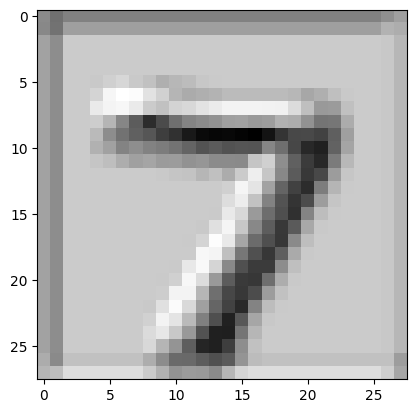

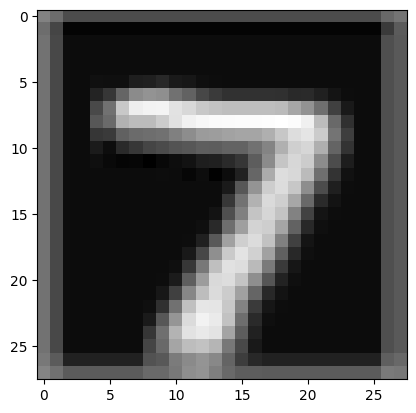

[[ -1.204  -3.396  -1.967  -1.967  -1.967  -1.967  -1.967  -1.967  -1.967
   -1.967  -1.967  -1.967  -1.967  -1.967  -1.967  -1.967  -1.967  -1.967
   -1.967  -1.967  -1.967  -1.967  -1.967  -1.967  -1.967  -1.967  -0.819
    0.354]
 [ -1.415  -3.216   0.436   0.436   0.436   0.436   0.436   0.436   0.436
    0.436   0.436   0.436   0.436   0.436   0.436   0.436   0.436   0.436
    0.436   0.436   0.436   0.436   0.436   0.436   0.436   0.436   1.851
    1.501]
 [  0.626  -1.004   4.12    4.12    4.12    4.12    4.12    4.12    4.12
    4.12    4.12    4.12    4.12    4.12    4.12    4.12    4.12    4.12
    4.12    4.12    4.12    4.12    4.12    4.12    4.12    4.12    3.818
    2.166]
 [  0.626  -1.004   4.12    4.12    4.12    4.12    4.12    4.12    4.12
    4.12    4.12    4.12    4.12    4.12    4.12    4.12    4.12    4.12
    4.12    4.12    4.12    4.12    4.12    4.12    4.12    4.12    3.818
    2.166]
 [  0.626  -1.004   4.12    4.12    4.12    4.12    4.12    4.12    4.12

In [107]:
base_input = model.layers[0].input
layer1_output1_np = np.round(tf.keras.Model(base_input, model.get_layer( model.layers[3].name ).output)(mnist_og)[0][:, :, 0].numpy().reshape(-1), 3)
layer1_output2_np = np.round(tf.keras.Model(base_input, model.get_layer( model.layers[3].name ).output)(mnist_og)[0][:, :, 1].numpy().reshape(-1), 3)
plt.imshow(layer1_output1_np.reshape((28,28)), cmap=cm.Greys_r)
plt.show()
plt.imshow(layer1_output2_np.reshape((28,28)), cmap=cm.Greys_r)
plt.show()
print(layer1_output1_np.reshape((28,28)))

In [27]:
for layer in model.layers:
    weights = layer.get_weights()
    print(f"Layer: {layer.name}")
    for weight in weights:
        print(weight)

Layer: conv1
[[[[-1.7398135e-01  1.2340679e-04 -2.7192792e-01 -6.6541183e-01]]

  [[-5.8440900e-01 -1.6950095e-01  1.4543304e-01 -3.5709238e-01]]

  [[-2.9479503e-04 -7.9024804e-04 -2.7189008e-03 -4.4049650e-01]]]


 [[[-5.0653338e-01  2.9291174e-01 -1.8281297e-01 -1.4276853e-03]]

  [[-2.3697148e-01  7.3679030e-01 -8.4928209e-01 -3.9625213e-01]]

  [[-2.5309993e-02  5.5447417e-01 -7.1532434e-01 -6.9154346e-01]]]


 [[[-3.8711518e-01  5.6564701e-01 -2.2411892e-02  3.2010639e-01]]

  [[ 1.5005492e-01  6.2405509e-01  8.2343124e-02  2.1383227e-04]]

  [[ 2.7859908e-01  1.2301529e-02 -1.3172439e-01 -3.5959122e-01]]]]
Layer: batchnormalize1
[0.9576254  0.9205803  1.01045    0.96566284]
[0.19741851 0.31281546 0.36535633 0.21576057]
[ 3.3540149 -3.4623423  3.3999054  3.0867217]
[7.5233674 7.684318  5.821779  6.350511 ]
Layer: activation1
Layer: conv2
[[[[ 1.05739169e-01  8.66116732e-02  4.75092798e-01 -4.29144017e-02]
   [-5.59307337e-02 -2.51138030e-04 -2.60159463e-01 -7.07649112e-01]
   [ 1

In [ ]:
conv1_weights = model.get_layer('conv1').get_weights()[0][:, :, 0, 3]
print("Unique weight values after binarization:", tf.sign(conv1_weights).numpy())

In [ ]:
conv1_weights = model.get_layer('batchnormalize1').get_weights()[:,:,0,0]
print("Unique weight values after binarization:", conv1_weights)

# Calculate network

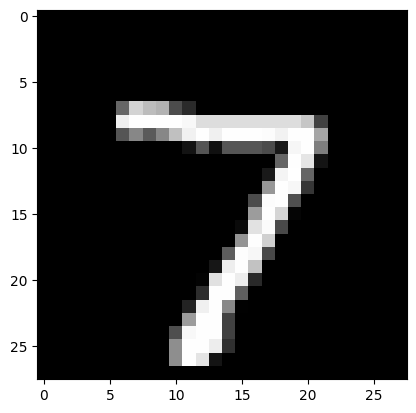

In [98]:
test = x_test[0]
plt.imshow(test, cmap=cm.Greys_r)
plt.show()
test = np.pad(test.reshape((28,28)), ((1, 1), (1, 1)), 'constant', constant_values=((0, 0), (0,0)))

## Conv1 + BM + RelU

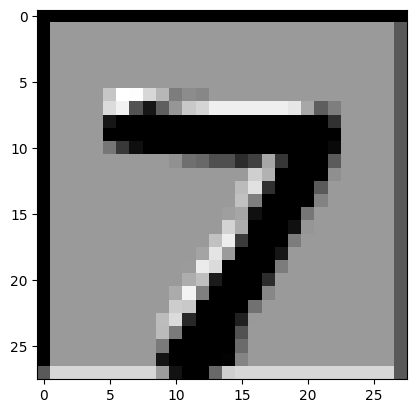

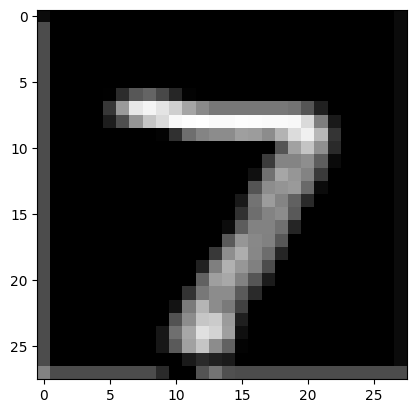

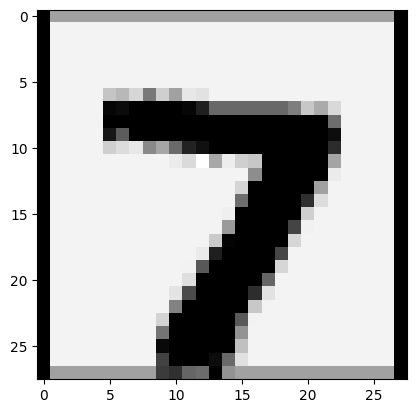

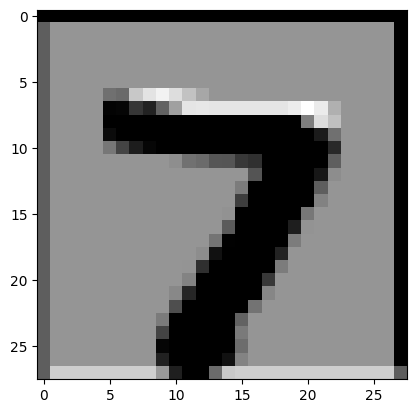

In [110]:
size_k = 4
a = np.zeros((size_k ,28,28))
for i in range(28):
    for j in range(28):
        for k in range(size_k):
            a[k][i][j]= np.sum(test.reshape((30,30))[i:i+3,j:j+3]*tf.sign(model.layers[0].get_weights()[0][:, :, 0, k]))
            a[k][i][j] = (a[k][i][j]-model.layers[1].get_weights()[2][k])/np.sqrt(model.layers[1].get_weights()[3][k])*model.layers[1].get_weights()[0][k]+model.layers[1].get_weights()[1][k]
            if a[k][i][j] < 0: a[k][i][j]=0

for k in range(size_k):
    plt.imshow(a[k], cmap=cm.Greys_r)
    plt.show()

## Conv2 + BM + RelU

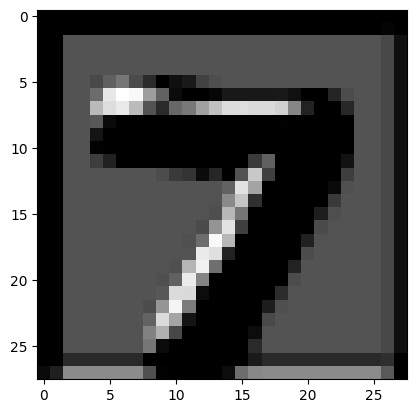

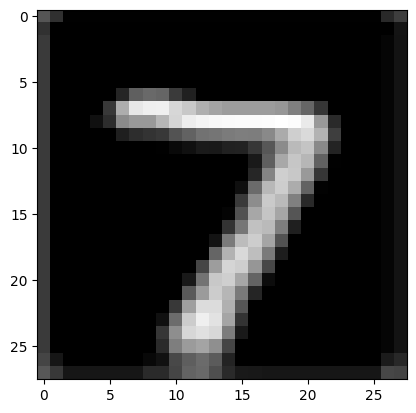

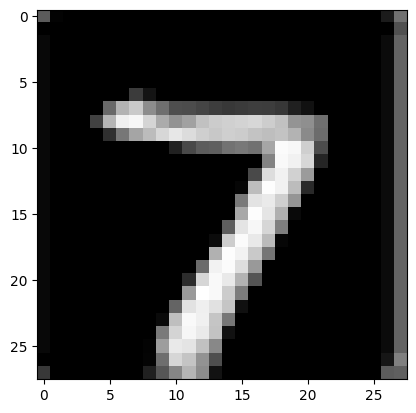

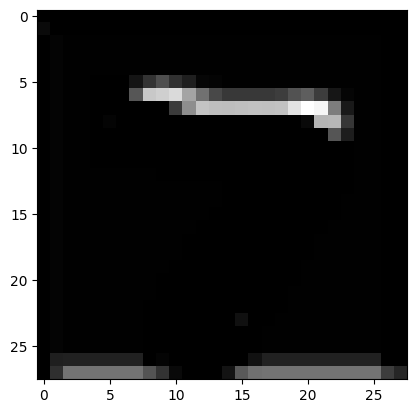

In [109]:
size_k = 4
size_w = 4
aa = np.zeros((size_k ,30,30))
for w in range(size_w):
    aa[w] = np.pad(a[w].reshape((28,28)), ((1, 1), (1, 1)), 'constant', constant_values=((0, 0), (0,0)))
b = np.zeros((size_k ,28,28))
for i in range(28):
    for j in range(28):
        for k in range(size_k):
            for w in range(size_w):
                b[k][i][j] = b[k][i][j] + np.sum(aa[w][i:i+3,j:j+3]*tf.sign(model.layers[3].get_weights()[0][:, :,w, k]))
            b[k][i][j] = (b[k][i][j]-model.layers[4].get_weights()[2][k])/np.sqrt(model.layers[4].get_weights()[3][k])*model.layers[4].get_weights()[0][k]+model.layers[4].get_weights()[1][k]
            if b[k][i][j] < 0: b[k][i][j]=0

for k in range(size_k):
    plt.imshow(b[k], cmap=cm.Greys_r)
    plt.show()

## Maxpool1

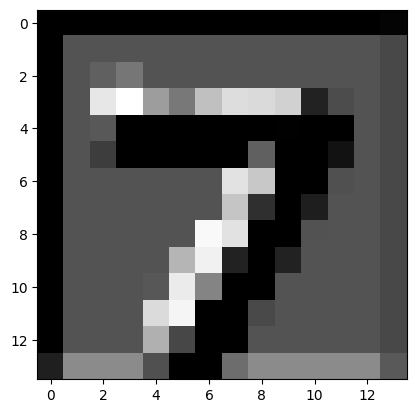

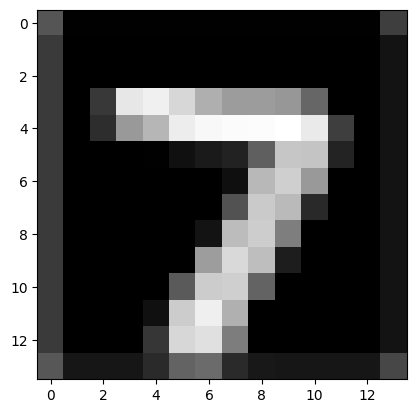

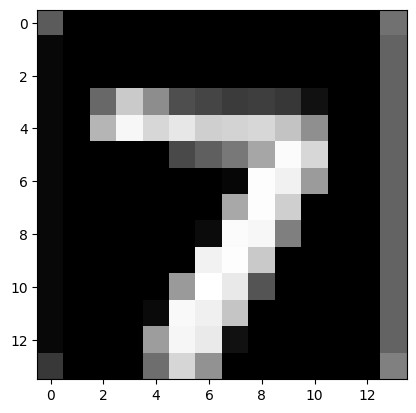

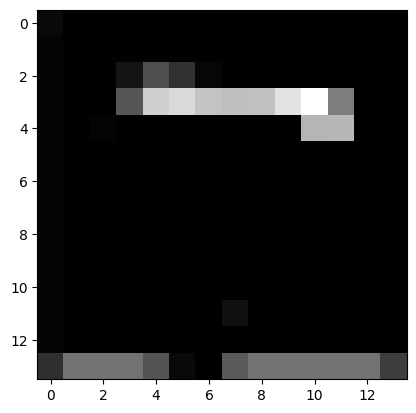

In [111]:
size_k = 4
c = np.zeros((size_k ,14,14))
for i in range(14):
    for j in range(14):
        for k in range(size_k):
            c[k][i][j]= np.max(b[k][2*i:2*i+2,2*j:2*j+2])

for k in range(size_k):
    plt.imshow(c[k], cmap=cm.Greys_r)
    plt.show()

## Conv3

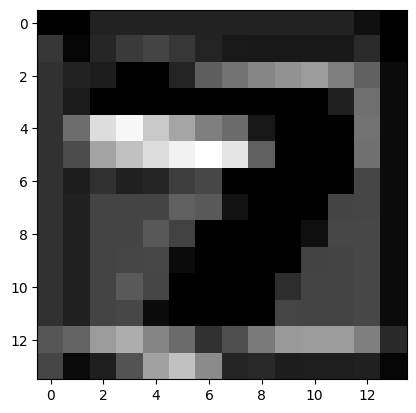

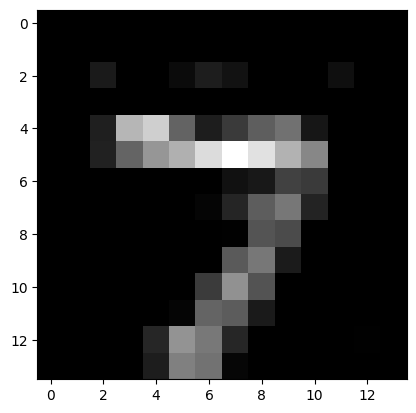

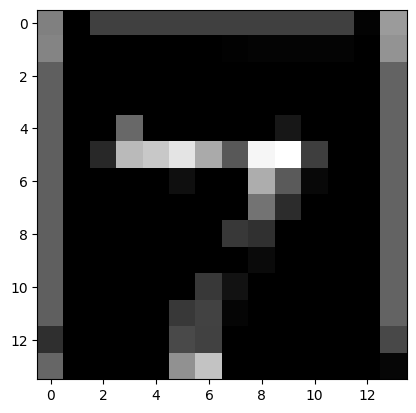

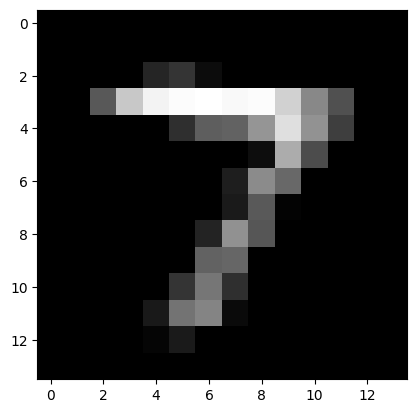

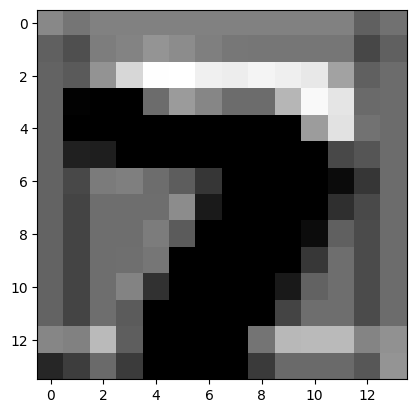

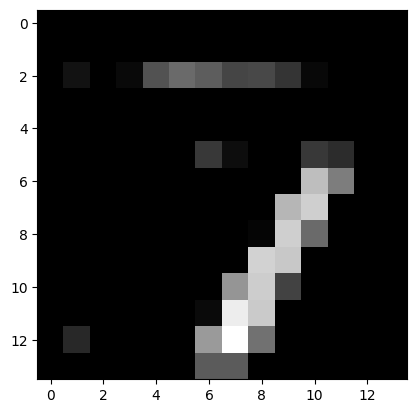

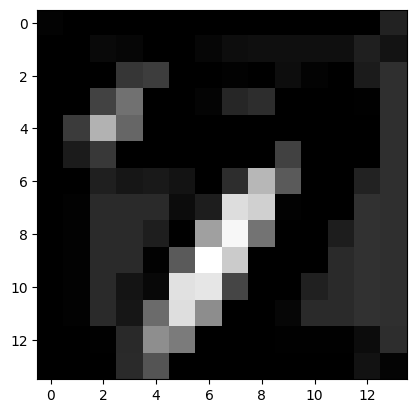

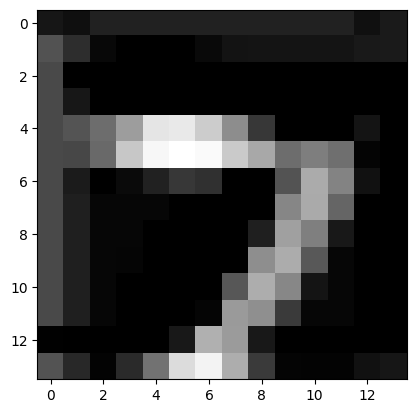

In [115]:
size_k = 8
size_w = 4
cc = np.zeros((size_w ,16,16))
for w in range(size_w):
    cc[w] = np.pad(c[w].reshape((14,14)), ((1, 1), (1, 1)), 'constant', constant_values=((0, 0), (0,0)))
d = np.zeros((size_k ,14,14))
for i in range(14):
    for j in range(14):
        for k in range(size_k):
            for w in range(size_w):
                d[k][i][j] = d[k][i][j] + np.sum(cc[w][i:i+3,j:j+3]*tf.sign(model.layers[7].get_weights()[0][:, :,w, k]))
            d[k][i][j] = (d[k][i][j]-model.layers[8].get_weights()[2][k])/np.sqrt(model.layers[8].get_weights()[3][k])*model.layers[8].get_weights()[0][k]+model.layers[8].get_weights()[1][k]
            if d[k][i][j] < 0: d[k][i][j]=0

for k in range(size_k):
    plt.imshow(d[k], cmap=cm.Greys_r)
    plt.show()

## Conv4

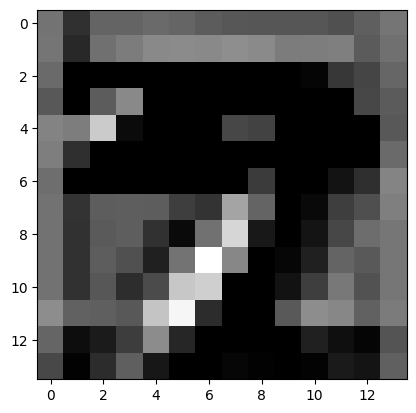

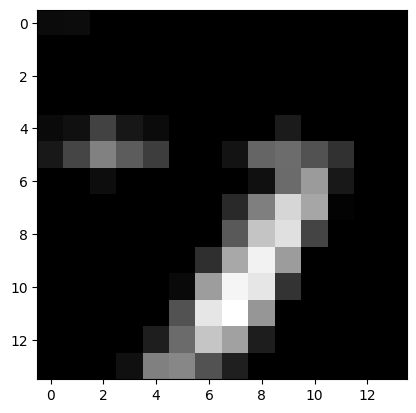

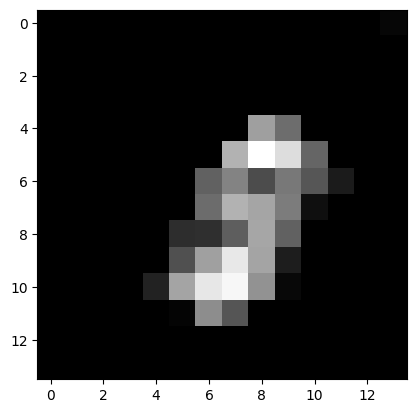

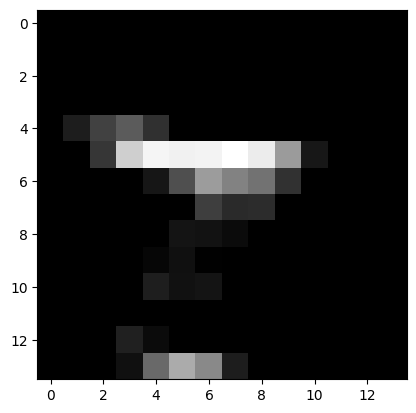

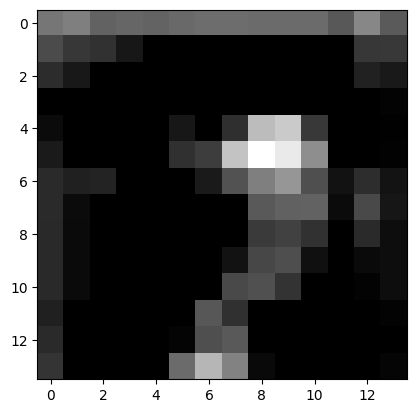

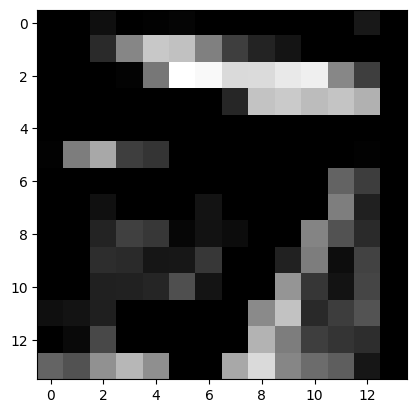

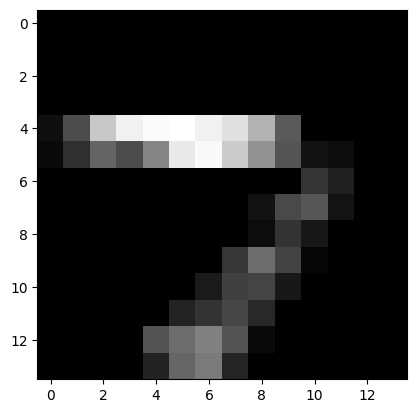

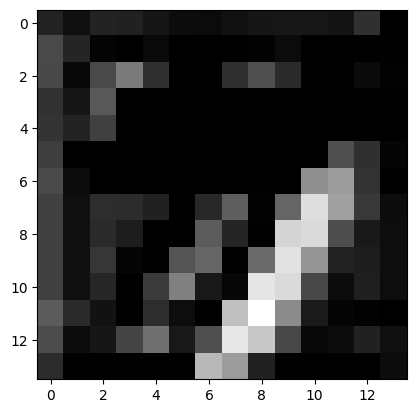

In [117]:
size_k = 8
size_w = 8
dd = np.zeros((size_k ,16,16))
for w in range(size_w):
    dd[w] = np.pad(d[w].reshape((14,14)), ((1, 1), (1, 1)), 'constant', constant_values=((0, 0), (0,0)))
e = np.zeros((size_k ,14,14))
for i in range(14):
    for j in range(14):
        for k in range(size_k):
            for w in range(size_w):
                e[k][i][j] = e[k][i][j] + np.sum(dd[w][i:i+3,j:j+3]*tf.sign(model.layers[10].get_weights()[0][:, :,w, k]))
            e[k][i][j] = (e[k][i][j]-model.layers[11].get_weights()[2][k])/np.sqrt(model.layers[11].get_weights()[3][k])*model.layers[11].get_weights()[0][k]+model.layers[11].get_weights()[1][k]
            if e[k][i][j] < 0: e[k][i][j]=0

for k in range(size_k):
    plt.imshow(e[k], cmap=cm.Greys_r)
    plt.show()

## Maxpool2

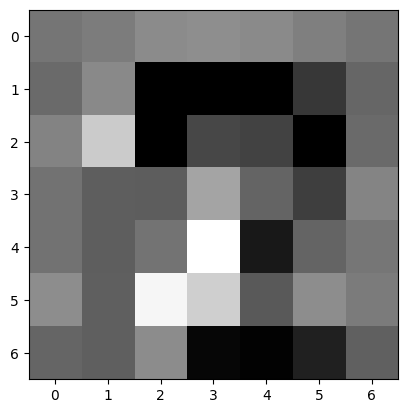

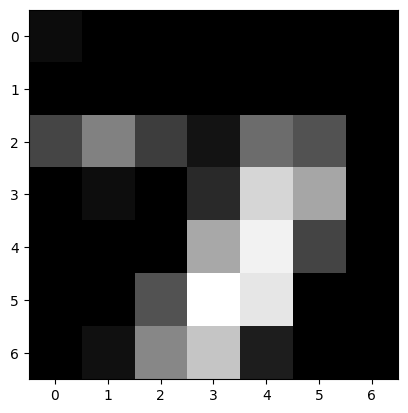

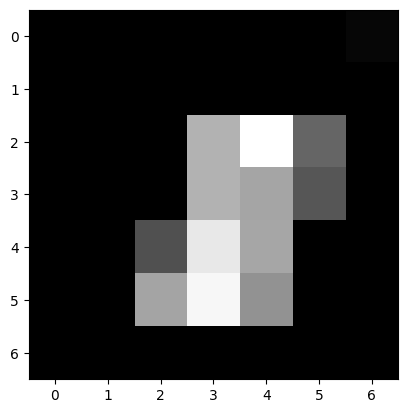

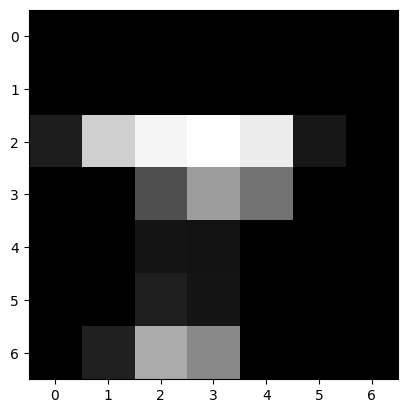

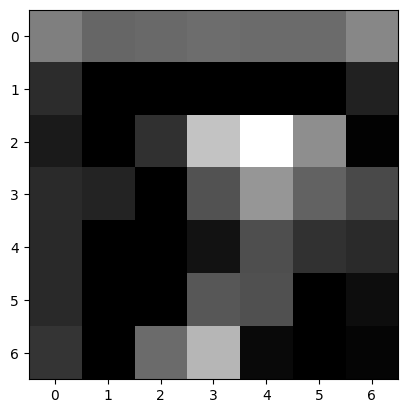

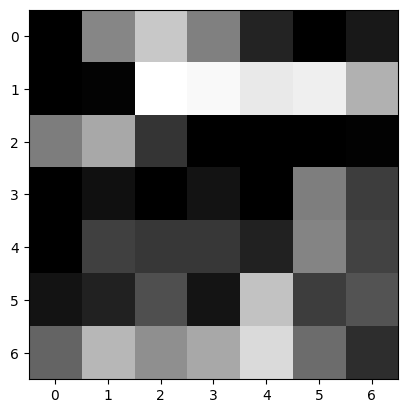

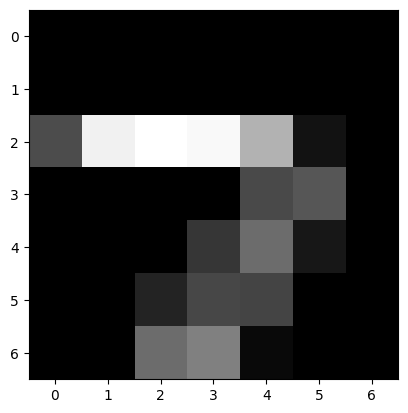

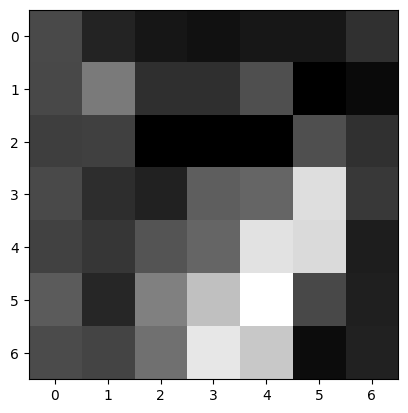

In [118]:
size_k = 8
f = np.zeros((size_k ,7,7))
for i in range(7):
    for j in range(7):
        for k in range(size_k):
            f[k][i][j]= np.max(e[k][2*i:2*i+2,2*j:2*j+2])

for k in range(size_k):
    plt.imshow(f[k], cmap=cm.Greys_r)
    plt.show()

## Conv5

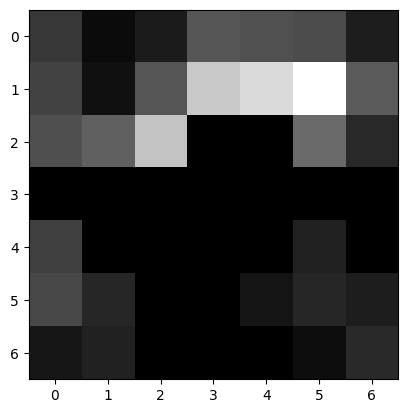

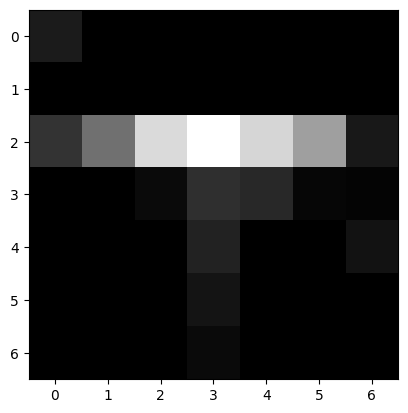

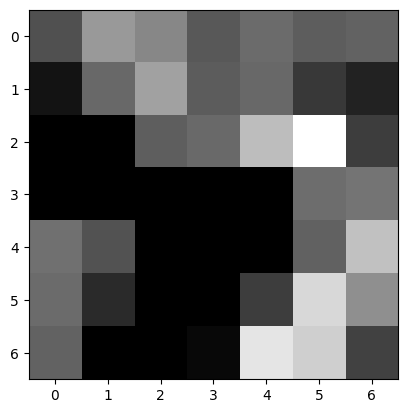

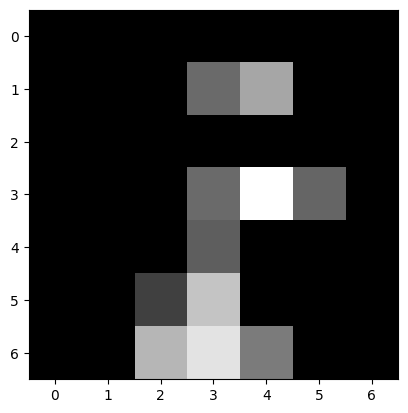

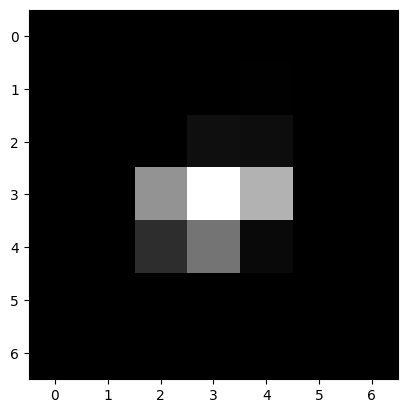

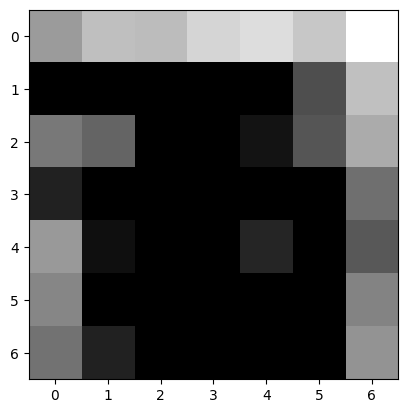

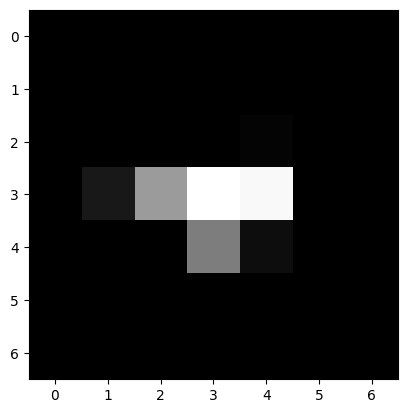

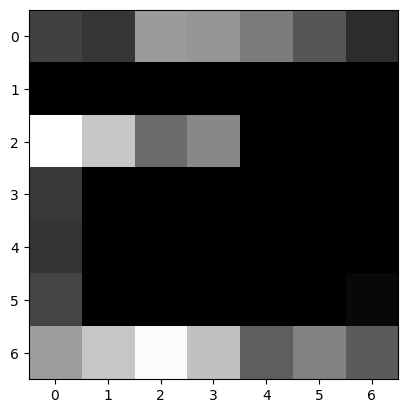

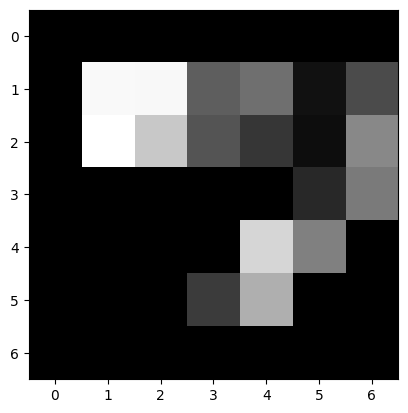

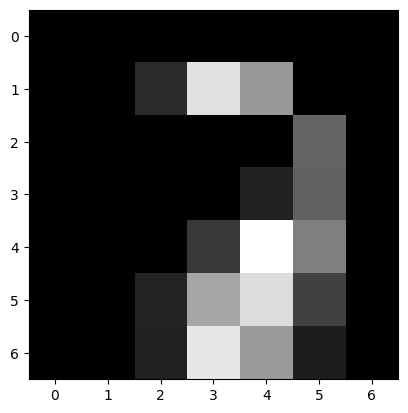

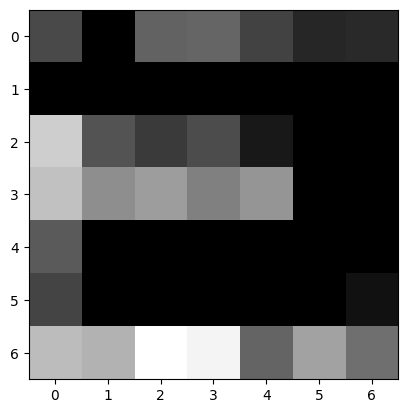

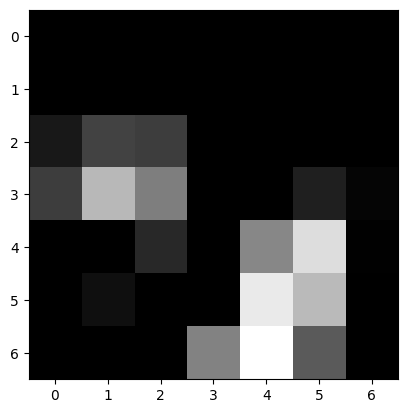

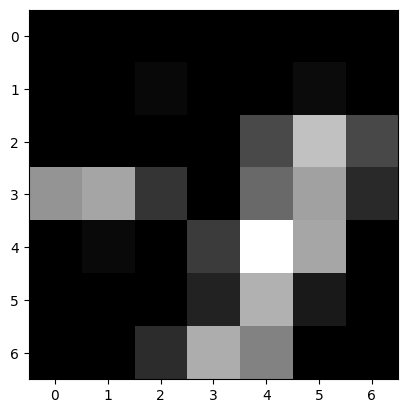

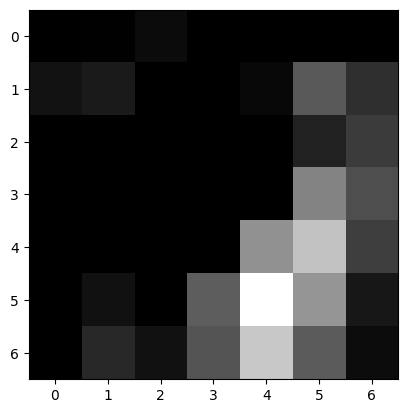

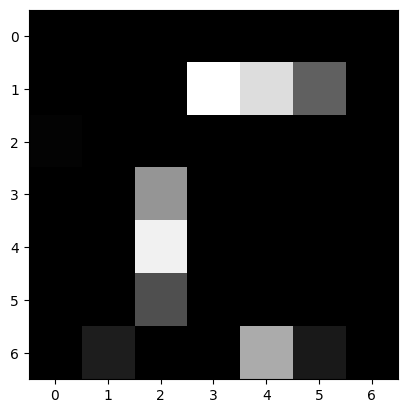

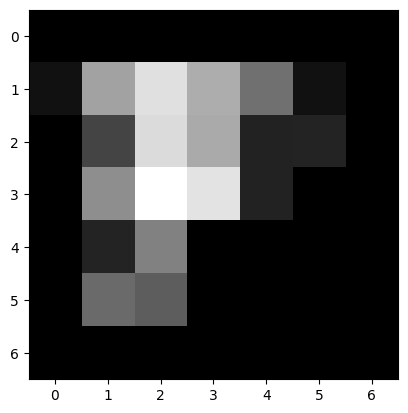

In [120]:
size_k = 16
size_w = 8
ff = np.zeros((size_w ,9,9))
for w in range(size_w):
    ff[w] = np.pad(f[w].reshape((7,7)), ((1, 1), (1, 1)), 'constant', constant_values=((0, 0), (0,0)))
g = np.zeros((size_k ,7,7))
for i in range(7):
    for j in range(7):
        for k in range(size_k):
            for w in range(size_w):
                g[k][i][j] = g[k][i][j] + np.sum(ff[w][i:i+3,j:j+3]*tf.sign(model.layers[14].get_weights()[0][:, :,w, k]))
            g[k][i][j] = (g[k][i][j]-model.layers[15].get_weights()[2][k])/np.sqrt(model.layers[15].get_weights()[3][k])*model.layers[15].get_weights()[0][k]+model.layers[15].get_weights()[1][k]
            if g[k][i][j] < 0: g[k][i][j]=0

for k in range(size_k):
    plt.imshow(g[k], cmap=cm.Greys_r)
    plt.show()

## Global Maxpool

In [124]:
size_k = 16
h = np.zeros((size_k))
for k in range(size_k):
    h[k]= np.max(g[k])

print(h)

[2.34116126 4.00427362 2.41660188 2.30821862 4.45889159 2.26252119
 3.8738175  1.91130919 2.24177572 1.722848   1.83343542 3.09594994
 3.63867594 3.85560987 1.3796967  4.26611894]


In [126]:
i = np.array([])
for k in range(10):
    i = np.append(i,np.sum(np.round(model.layers[18].get_weights()[0][:, k], 3)*h) + np.round(model.layers[18].get_weights()[1][k], 3))
print(i)

[-2.23110804 -2.22174013  0.44178588 -2.72819189 -1.42039318 -2.73860727
 -6.04744194  3.72164415 -3.75969466 -1.56776499]


In [127]:
np.argmax(i)

np.int64(7)

# Extract Weight

In [3]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

plt.imshow(x_train[1], cmap=cm.Greys_r)
plt.show()
print(x_train[1])

NameError: name 'datasets' is not defined

In [21]:
f = open("demofile2.txt", "w")
cnt = 0
i = 0
while (cnt<10):
    if(y_test[i] == cnt):
        print(cnt)
        cnt +=1
        for j in range(28):
            for k in range(28):
                f.write("%0.2X" % x_test[i][j][k]+'\n')
    i+=1

f.close()

0
1
2
3
4
5
6
7
8
9


In [30]:
map1 = np.array([0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 105,   0, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 105,   0, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 105,   0, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 196, 208, 217, 206, 281, 363, 322, 239, 206, 468, 427, 277, 110, 105, 194, 194, 105,   0, 194, 194, 194, 194, 194, 194, 215, 240, 263, 341, 352, 366, 400, 332, 257, 175,  46,  60,  78, 108,   0,   0,   0,  61, 194, 194, 105,   0, 194, 194, 194, 194, 194, 228, 372, 455, 269, 172,  77,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  61, 194, 194, 105,   0, 194, 194, 194, 194, 194, 172, 138,  88,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 149, 194, 194, 105,   0, 194, 194, 194, 194, 194, 147,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  15,  41,  71, 128, 167, 194, 194, 194, 105,   0, 194, 194, 194, 194, 194, 181,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 194, 194, 194, 194, 194, 194, 194, 194, 105,   0, 194, 194, 194, 194, 194, 194, 138,  20,   0,   0,   0,   0,   0,   0, 155,  57,  57,  87, 194, 194, 194, 194, 194, 194, 194, 194, 105,   0, 194, 194, 194, 194, 194, 194, 194, 184, 183,   0,   0,   0,   0,   0, 144, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 105,   0, 194, 194, 194, 194, 194, 194, 194, 194, 194,  89,   0,   0,   0,   0, 174, 158, 119, 193, 194, 194, 194, 194, 194, 194, 194, 194, 105,   0, 194, 194, 194, 194, 194, 194, 194, 194, 194, 186,  30,   0,   0,   0,   0,  89,  42, 128, 176, 194, 194, 194, 194, 194, 194, 194, 105,   0, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 169,   0,   0,   0,   0,   0,   0,  40,  91, 175, 194, 194, 194, 194, 194, 194, 105,   0, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 137,   0,   0,   0,   0,   0,   0,   7,  45, 194, 194, 194, 194, 194, 194, 105,   0, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 162,  22,   0,   0,   0,   0,   0,   0, 149, 194, 194, 194, 194, 194, 105,   0, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 226, 305, 304,   0,   0,   0,   0,   0, 148, 194, 194, 194, 194, 194, 105,   0, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 221, 324, 397, 304, 137,   0,   0,   0,   0,   0, 148, 194, 194, 194, 194, 194, 105,   0, 194, 194, 194, 194, 194, 194, 194, 194, 210, 290, 383, 314,  71,   0,   0,   0,   0,   0,   0,   0, 192, 194, 194, 194, 194, 194, 105,   0, 194, 194, 194, 194, 194, 194, 210, 256, 355, 376, 121,   0,   0,   0,   0,   0,   0,   0,   0,  67, 194, 194, 194, 194, 194, 194, 105,   0, 194, 194, 194, 194, 206, 325, 436, 341, 167,   0,   0,   0,   0,   0,   0,   0,   0,   0, 140, 194, 194, 194, 194, 194, 194, 194, 105,   0, 194, 194, 232, 352, 420, 276,  89,   0,   0,   0,   0,   0,   0,   0,   0,   0, 136, 192, 194, 194, 194, 194, 194, 194, 194, 194, 105,   0, 194, 194, 250, 306, 124,   0,   0,   0,   0,   0,   0,   0,   0,   0, 132, 188, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 105,   0, 194, 194,  61,   0,   0,   0,   0,   0, 0,   0,   0,   0,  94, 186, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 105,   0, 194, 194,  99,   0,   0,   0,   0,   0,   0,   0,  91, 183, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 105,   0, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 105, 105, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282,105])
map2 = np.array([35,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  58, 136, 240, 174, 194, 247, 394, 368, 199,  34,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0,   0,   0,  56, 139, 230, 347, 425, 490, 562, 640, 726, 606, 626, 690, 852, 701, 371,  77,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0, 161, 353, 550, 643, 730, 823, 881, 946, 875, 795, 709, 622, 541, 277, 303, 267, 228,  77,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0, 278, 590, 859, 817, 805, 780, 699, 707, 703, 730, 521, 297,   0,   0,   0,   2,  63,   0,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0,   0, 139, 481, 629, 693, 758, 561, 346, 234, 359, 345, 263,   0,   0,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0,   0,   0,   0, 237, 460, 584, 358,  69,   0,   0,  85, 212,   0,   0,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0,   0,   0,   0,  19, 216, 531, 498, 266,   0,   0,   0,  52,   0,   0,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  74, 513, 695, 352,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 233, 664, 705, 325, 129,  23,   0,   0,   0,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 408, 869, 819, 544, 286,  46,   0,   0,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0,   0,0,   0,   0,   0,   0,   0, 389, 738, 859, 720, 332,  84,   0,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 167, 570, 855, 758, 376,  92,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 143, 581, 959, 700, 300,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  56, 116, 273, 467, 798, 677, 421,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  74, 257, 485, 677, 665, 576, 711, 504, 333,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 214, 465, 679, 756, 765, 720, 591, 453, 318, 207,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0,   0,   9, 167, 395, 640, 720, 713, 700, 624, 438, 193,  18,  47,  71,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,   0,   0,   0,  76, 236, 436, 616, 716, 725, 681, 616, 438, 195,   9,   0,  33,   2,   0,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,   0, 101, 263, 508, 692, 822, 766, 687, 678, 505, 228,  15,   0,  33,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,  77, 359, 665, 761, 666, 653, 582, 468, 299,  89,  31,  28,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,   4,  58, 149, 250, 241, 181, 100,   0,   0,  27,  31,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  27,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  35, 204,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  35, 374, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204,204])
map3 = np.array([0, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155,   0,   0, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,   0,   0, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,   0,   0, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,   0,   0, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 259, 249, 259, 246, 156, 238, 123, 272,   0, 165, 129, 149, 161, 155, 261, 261,   0,   0, 261, 261, 261, 261, 261, 261, 236, 256, 188, 181, 167,  46,  87,   5,   0,   0,   0,   0,   0,   0,   0,   0,   0, 102, 261, 261,   0,   0, 261, 261, 261, 261, 261, 220,  78, 153,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 102, 261, 261,   0,   0, 261, 261, 261, 261, 261, 205,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  89, 119, 208, 261, 261,   0,   0, 261, 261, 261, 261, 261, 205,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 184, 215, 207, 247, 229, 261, 261, 261,   0,   0, 261, 261, 261, 261, 261, 246,  27,   9,   0,   0,   0,   0,   0,   0,   0,   0,  92,   0, 261, 261, 261, 261, 261, 261, 261, 261,   0,   0, 261, 261, 261, 261, 261, 261, 195, 186, 223,   0,   0,   0,   0,   0, 215, 169, 354, 133, 261, 261, 261, 261, 261, 261, 261, 261,   0,   0, 261, 261, 261, 261, 261, 261, 261, 250, 272,   0,   0,   0,   0,   0, 201, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,   0,   0, 261, 261, 261, 261, 261, 261, 261, 261, 261, 136,   0,   0,   0,   0,  57, 217, 172, 261, 261, 261, 261, 261, 261, 261, 261, 261,   0,   0, 261, 261, 261, 261, 261, 261, 261, 261, 261, 252,  83,   0,   0,   0,   0,   0,  37, 182, 241, 261, 261, 261, 261, 261, 261, 261,   0,   0, 261, 261, 261, 261, 261, 261, 261,261, 261, 261, 232,  21,   0,   0,   0,   0,   0,  32, 138, 239, 261, 261, 261, 261, 261, 261,   0,   0, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 194,  91,   0,   0,   0,   0,   0,  37,  83, 261, 261, 261, 261, 261, 261,   0,   0, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 224, 130,  77,   0,   0,   0,   0,   0, 208, 261, 261, 261, 261, 261,   0,   0, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 223, 178, 114,   0,   0,   0,   0,   0, 206, 261, 261, 261, 261, 261,   0,   0, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 229, 170, 123,   0,   0,   0,   0,   0,   0,   0, 206, 261, 261, 261, 261, 261,   0,   0, 261, 261, 261, 261, 261, 261, 261, 261, 241, 186, 119,   0,   0,   0,   0,   0,   0,   0,   0,   0, 260, 261, 261, 261, 261, 261,   0,   0, 261, 261, 261, 261, 261, 261, 242, 225,  99,  57,   0,   0,   0,   0,   0,   0,   0,   0, 139, 109, 261, 261, 261, 261, 261, 261,   0,   0, 261, 261, 261, 261, 246, 134, 187,  16,   0,   0,   0,   0,   0,   0,   0,   0,  83, 157, 196, 261, 261, 261, 261, 261, 261, 261,   0,   0, 261, 261, 215, 164, 155,   0,   0,   0,   0,   0,   0,   0,   0,   0,  73, 154, 195, 260, 261, 261, 261, 261, 261, 261, 261, 261,   0,   0, 261, 261, 102,   0,   0,   0,   0,   0,   0,   0,   0,   0,  26, 149, 202, 254, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,   0,   0, 261, 261, 102,   0,   0,   0,   0,   0,   0,   0,  19, 146, 159, 252, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,   0,   0, 261, 261, 148, 164, 148,  50,  84, 114,  87, 246, 164, 248, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,   0,   0, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,   0,   0, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155,0])
map4 = np.array([0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 142, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240,   0, 142, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240,   0, 142, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240,   0, 142, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 237, 228, 242, 253, 171, 246, 306, 458, 266, 191, 373, 527, 526, 337, 240, 240,   0, 142, 240, 240, 240, 240, 240, 240, 217, 235, 218, 221, 297, 278, 340, 392, 309, 219, 120, 216,  69,  37,   0,  44, 152, 191, 240, 240,   0, 142, 240, 240, 240, 240, 240, 202,  72, 215, 299, 216, 111,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  93, 240, 240,   0, 142, 240, 240, 240, 240, 240, 188,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  11, 191, 240, 240,   0, 142, 240, 240, 240, 240, 240, 188,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  43,  71, 104, 167, 210, 240, 240, 240,   0, 142, 240, 240, 240, 240, 240, 226,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 240, 240, 240, 240, 240, 240, 240, 240,   0, 142, 240, 240, 240, 240, 240, 240, 178,  48,   0,   0,   0,   0,   0, 152, 200,  89,  89, 122, 240, 240, 240, 240, 240, 240, 240, 240,   0, 142, 240, 240, 240, 240, 240, 240, 240, 229, 228,   0,   0,   0,   0, 271, 292, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240,   0, 142, 240, 240, 240, 240, 240, 240, 240, 240, 240, 125,   0,   0,   0,  80, 397, 444, 323, 240, 240, 240, 240, 240, 240, 240, 240, 240,   0, 142, 240, 240, 240, 240, 240, 240, 240, 240, 240, 231,  59,   0,   0,   0,   0, 330, 422, 349, 259, 240, 240, 240, 240, 240, 240, 240,   0, 142, 240, 240, 240, 240, 240, 240, 240,240, 240, 240, 213,   0,   0,   0,   0,   0, 125, 416, 356, 260, 240, 240, 240, 240, 240, 240,   0, 142, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 178,   0,   0,   0,   0,   0,  44, 422, 362, 240, 240, 240, 240, 240, 240,   0, 142, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 205,  50,   0,   0,   0,   0, 103, 315, 289, 240, 240, 240, 240, 240,   0, 142, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 204, 163, 151,   0,   0,   0,   0,  17, 192, 240, 240, 240, 240, 240,   0, 142, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 210, 156, 172, 200, 140,   0,   0,   0,   0,   0, 189, 240, 240, 240, 240, 240,   0, 142, 240, 240, 240, 240, 240, 240, 240, 240, 221, 171, 146, 159,  55,   0,   0,   0,   0,   0,   0,   0, 238, 240, 240, 240, 240, 240,   0, 142, 240, 240, 240, 240, 240, 240, 222, 207, 126, 154,  98,   0,   0,   0,   0,   0,   0,   0,   0, 100, 240, 240, 240, 240, 240, 240,   0, 142, 240, 240, 240, 240, 226, 122, 199, 276, 158,   0,   0,   0,   0,   0,   0,   0,   0,  24, 180, 240, 240, 240, 240, 240, 240, 240,   0, 142, 240, 240, 197, 150, 227, 206,  83,   0,   0,   0,   0,   0,   0,   0,   0,  18, 176, 238, 240, 240, 240, 240, 240, 240, 240, 240,   0, 142, 240, 240,  93,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  14, 171, 233, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240,   0, 142, 240, 240,  93,   0,   0,   0,   0,   0,   0,   0,   0,   0, 129, 231, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240,   0, 142, 240, 240, 135,   0,   0,   0,   0,   0,   0,  23, 126, 227, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240,   0, 142, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240, 240,   0, 142, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337,142]) 
print(len(map1))
print(len(map2))
print(len(map3))
print(len(map4))

784
784
784
784


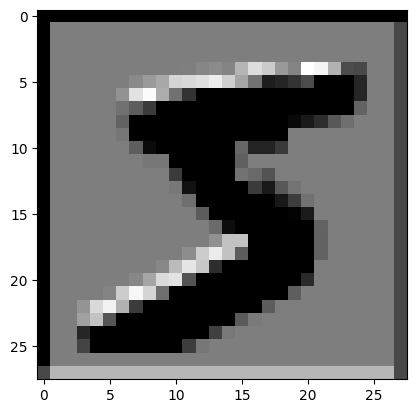

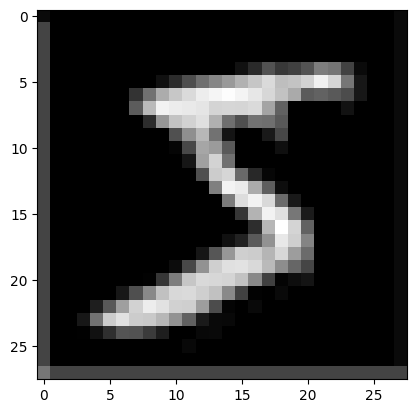

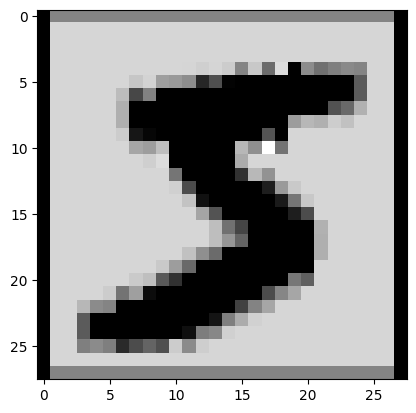

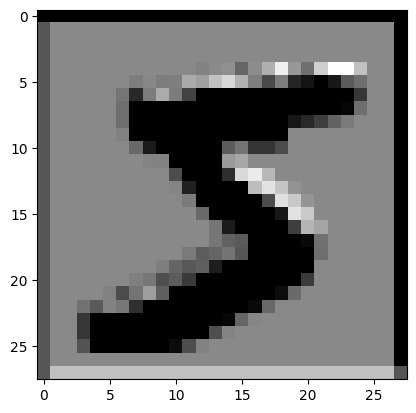

In [31]:
map = np.array([map1, map2, map3, map4])
for m in map:
    m = m.reshape(28,28)/255
    plt.imshow(m, cmap=cm.Greys_r)
    plt.show()

In [4]:
import numpy as np
def read_mem_file(filename):
    data_array = []
    first_data_line = True  # Flag to handle address in first line

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            
            # Skip comment lines and empty lines
            if not line or line.startswith('//'):
                continue

            # Split line into tokens
            tokens = line.split()
            
            # Handle first data line containing address
            # if first_data_line:
            #     # Remove the address (first token) and process remaining data
            #     data_tokens = tokens[1:]
            #     first_data_line = False
            # else:
                # Process all tokens as data
            data_tokens = tokens

            # Convert each 3-character hex value to 12-bit integer
            for token in data_tokens:
                if token == 'xxx':
                    # data_array.append(0)
                    return data_array
                # Handle hex values and force 12-bit range (0-4095)
                value = int(token, 16) & 0xFFF
                data_array.append(value)

    return data_array

# Usage example


Read 12169 12-bit values:
[0, 3841, 3841, 3841, 3841, 3841, 3841, 3841, 3841, 3841, 3841, 3841, 3841, 3841, 3841, 3841, 3841, 3841, 3841, 3841]


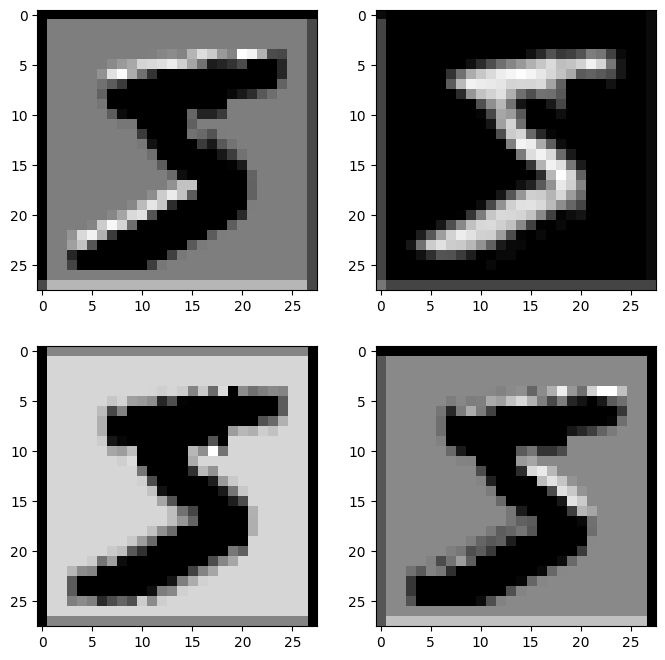

In [7]:
mem_data = read_mem_file('ram.mem')
print(f"Read {len(mem_data)} 12-bit values:")
print(mem_data[:20])  # Print first 20 values as sample

images = []
for i in range(4):
    startaddr = 785+784*i
    endaddr = startaddr+784
    m = np.array(mem_data[startaddr:endaddr])
    m = m.reshape(28,28)/255
    images.append(m)
# print(m)
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes[0,0].imshow(images[0], cmap=cm.Greys_r)
axes[0,1].imshow(images[1], cmap=cm.Greys_r)
axes[1,0].imshow(images[2], cmap=cm.Greys_r)
axes[1,1].imshow(images[3], cmap=cm.Greys_r)
# plt.imshow(m, cmap=cm.Greys_r)
plt.show()

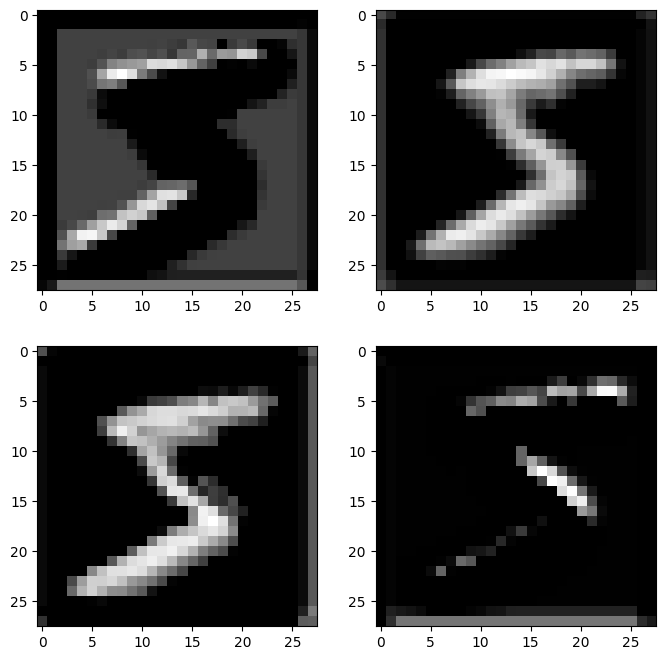

In [8]:
images = []
for i in range(4):
    startaddr = 785+784*4+784*i
    endaddr = startaddr+784
    m = np.array(mem_data[startaddr:endaddr])
    m = m.reshape(28,28)/255
    images.append(m)
# print(m)
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes[0,0].imshow(images[0], cmap=cm.Greys_r)
axes[0,1].imshow(images[1], cmap=cm.Greys_r)
axes[1,0].imshow(images[2], cmap=cm.Greys_r)
axes[1,1].imshow(images[3], cmap=cm.Greys_r)
# plt.imshow(m, cmap=cm.Greys_r)
plt.show()

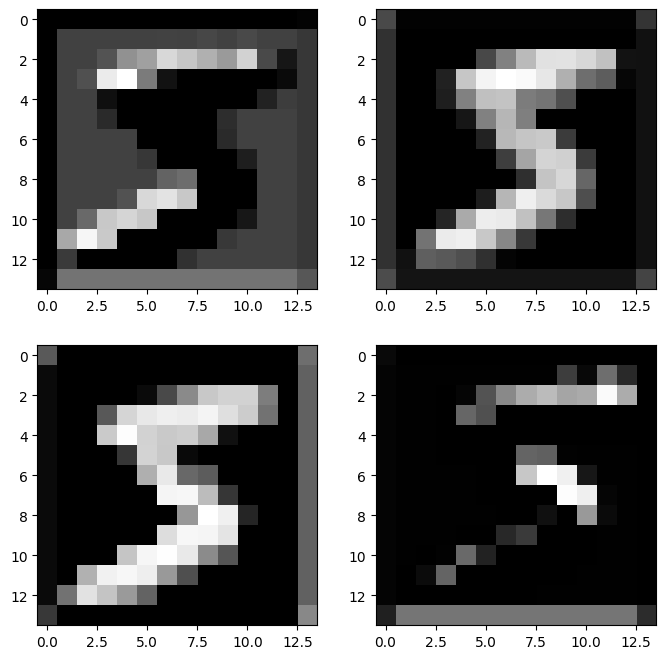

In [10]:
images = []
for i in range(4):
    startaddr = 7057+196*i
    endaddr = startaddr+196
    m = np.array(mem_data[startaddr:endaddr])
    m = m.reshape(14,14)/255
    images.append(m)
# print(m)
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes[0,0].imshow(images[0], cmap=cm.Greys_r)
axes[0,1].imshow(images[1], cmap=cm.Greys_r)
axes[1,0].imshow(images[2], cmap=cm.Greys_r)
axes[1,1].imshow(images[3], cmap=cm.Greys_r)
# plt.imshow(m, cmap=cm.Greys_r)
plt.show()

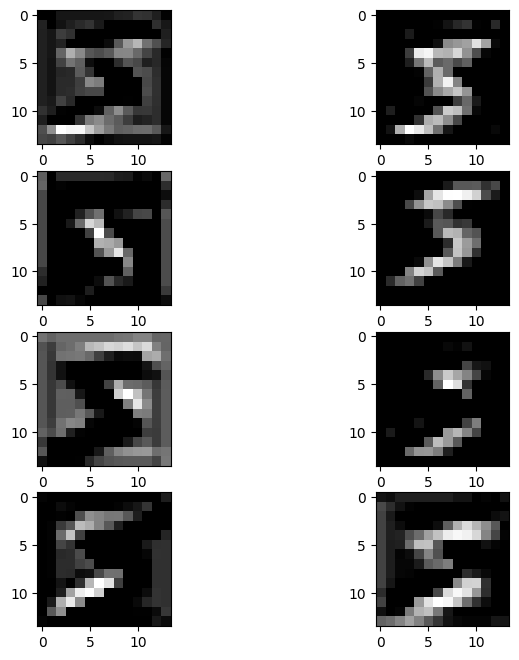

In [12]:
images = []
for i in range(8):
    startaddr = 7841+196*i
    endaddr = startaddr+196
    m = np.array(mem_data[startaddr:endaddr])
    m = m.reshape(14,14)/255
    images.append(m)
# print(m)
fig, axes = plt.subplots(4, 2, figsize=(8, 8))
axes[0,0].imshow(images[0], cmap=cm.Greys_r)
axes[0,1].imshow(images[1], cmap=cm.Greys_r)
axes[1,0].imshow(images[2], cmap=cm.Greys_r)
axes[1,1].imshow(images[3], cmap=cm.Greys_r)

axes[2,0].imshow(images[4], cmap=cm.Greys_r)
axes[2,1].imshow(images[5], cmap=cm.Greys_r)
axes[3,0].imshow(images[6], cmap=cm.Greys_r)
axes[3,1].imshow(images[7], cmap=cm.Greys_r)
# plt.imshow(m, cmap=cm.Greys_r)
plt.show()

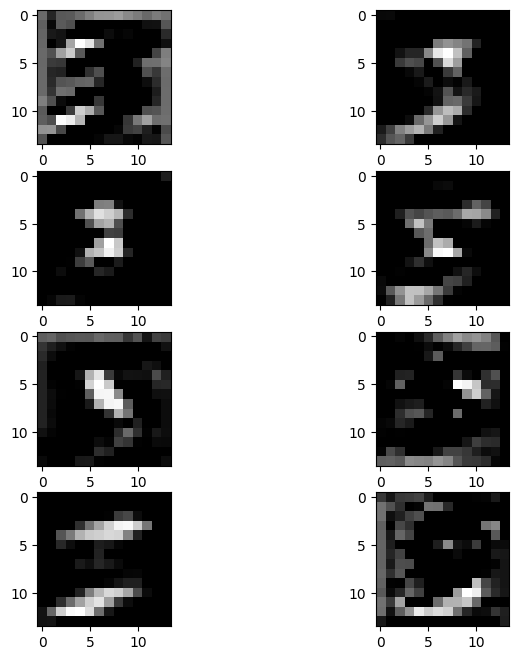

In [13]:
images = []
for i in range(8):
    startaddr = 9409+196*i
    endaddr = startaddr+196
    m = np.array(mem_data[startaddr:endaddr])
    m = m.reshape(14,14)/255
    images.append(m)
# print(m)
fig, axes = plt.subplots(4, 2, figsize=(8, 8))
axes[0,0].imshow(images[0], cmap=cm.Greys_r)
axes[0,1].imshow(images[1], cmap=cm.Greys_r)
axes[1,0].imshow(images[2], cmap=cm.Greys_r)
axes[1,1].imshow(images[3], cmap=cm.Greys_r)

axes[2,0].imshow(images[4], cmap=cm.Greys_r)
axes[2,1].imshow(images[5], cmap=cm.Greys_r)
axes[3,0].imshow(images[6], cmap=cm.Greys_r)
axes[3,1].imshow(images[7], cmap=cm.Greys_r)
# plt.imshow(m, cmap=cm.Greys_r)
plt.show()

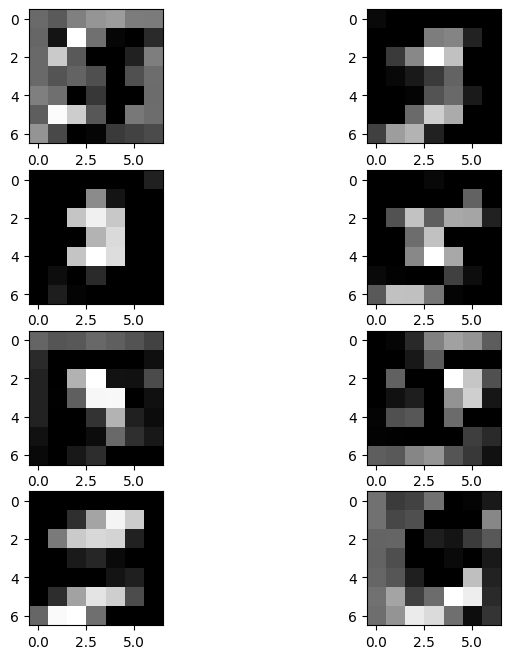

In [14]:
images = []
for i in range(8):
    startaddr = 10977+49*i
    endaddr = startaddr+49
    m = np.array(mem_data[startaddr:endaddr])
    m = m.reshape(7,7)/255
    images.append(m)
# print(m)
fig, axes = plt.subplots(4, 2, figsize=(8, 8))
axes[0,0].imshow(images[0], cmap=cm.Greys_r)
axes[0,1].imshow(images[1], cmap=cm.Greys_r)
axes[1,0].imshow(images[2], cmap=cm.Greys_r)
axes[1,1].imshow(images[3], cmap=cm.Greys_r)

axes[2,0].imshow(images[4], cmap=cm.Greys_r)
axes[2,1].imshow(images[5], cmap=cm.Greys_r)
axes[3,0].imshow(images[6], cmap=cm.Greys_r)
axes[3,1].imshow(images[7], cmap=cm.Greys_r)
# plt.imshow(m, cmap=cm.Greys_r)
plt.show()

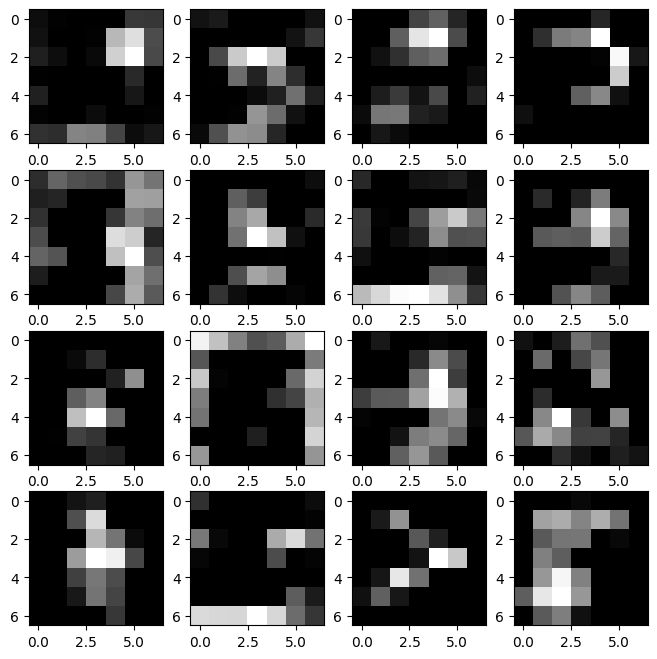

In [15]:
images = []
for i in range(16):
    startaddr = 11369+49*i
    endaddr = startaddr+49
    m = np.array(mem_data[startaddr:endaddr])
    m = m.reshape(7,7)/255
    images.append(m)
# print(m)
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes[0,0].imshow(images[0], cmap=cm.Greys_r)
axes[0,1].imshow(images[1], cmap=cm.Greys_r)
axes[1,0].imshow(images[2], cmap=cm.Greys_r)
axes[1,1].imshow(images[3], cmap=cm.Greys_r)

axes[2,0].imshow(images[4], cmap=cm.Greys_r)
axes[2,1].imshow(images[5], cmap=cm.Greys_r)
axes[3,0].imshow(images[6], cmap=cm.Greys_r)
axes[3,1].imshow(images[7], cmap=cm.Greys_r)

axes[0,2].imshow(images[8], cmap=cm.Greys_r)
axes[0,3].imshow(images[9], cmap=cm.Greys_r)
axes[1,2].imshow(images[10], cmap=cm.Greys_r)
axes[1,3].imshow(images[11], cmap=cm.Greys_r)

axes[2,2].imshow(images[12], cmap=cm.Greys_r)
axes[2,3].imshow(images[13], cmap=cm.Greys_r)
axes[3,2].imshow(images[14], cmap=cm.Greys_r)
axes[3,3].imshow(images[15], cmap=cm.Greys_r)
# plt.imshow(m, cmap=cm.Greys_r)
plt.show()

In [17]:
startaddr = 12153
endaddr = startaddr+16
m = np.array(mem_data[startaddr:endaddr])/256
print(m)

[5.2890625  3.92578125 3.0390625  5.07421875 4.171875   1.67578125
 3.1015625  3.1953125  5.9765625  1.45703125 4.11328125 4.57421875
 4.3671875  2.53125    2.23046875 4.1953125 ]
